In [125]:
import numpy
import tensorflow as tf
import json
import pandas

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

In [126]:
chips = numpy.load('../../chips/32_nw.npy')

In [127]:
chips.shape

(103050, 32, 32, 3)

In [128]:
sorter = numpy.random.choice(numpy.arange(0, len(chips)), len(chips))

In [129]:
chips = chips[sorter]

In [130]:
target = pandas.read_parquet("../../chips/32_nw/chip_proportions.pq").drop(columns="geometry").iloc[sorter]

<AxesSubplot:>

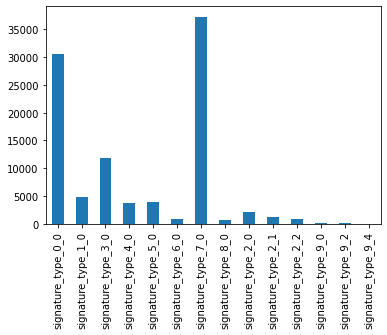

In [131]:
target.sum().plot.bar()

In [132]:
target.columns

Index(['signature_type_0_0', 'signature_type_1_0', 'signature_type_3_0',
       'signature_type_4_0', 'signature_type_5_0', 'signature_type_6_0',
       'signature_type_7_0', 'signature_type_8_0', 'signature_type_2_0',
       'signature_type_2_1', 'signature_type_2_2', 'signature_type_9_0',
       'signature_type_9_2', 'signature_type_9_4'],
      dtype='object')

In [133]:
with open('../../urbangrammar_samba/spatial_signatures/ai/gb_32_balanced_named_v2/json/efficientnet_pooling_256_12.json') as f:
    d = json.load(f)
    cd2nm = {}
    for codes, name in zip(d['meta_class_map'], d['meta_class_names']):
        for code in codes:
            cd2nm[f'signature_type_{code}'] = name.lower().replace(" ", "_").replace("/", "_")
    cd2nm = pandas.Series(cd2nm)
    
target = target.rename(columns=cd2nm).groupby(level=0, axis=1).sum()

In [134]:
mask = target.sum(axis=1) > 0.5
target_no_water = target[mask]
chips = chips[mask]

In [135]:
batch_size = 32
split = int(chips.shape[0] * 0.8)

train_dataset = tf.data.Dataset.from_tensor_slices((chips[:split], target_no_water.values[:split]))
test_dataset = tf.data.Dataset.from_tensor_slices((chips[split:], target_no_water.values[split:]))

train_dataset = train_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

In [136]:
preprocessing_and_augmentation = keras.Sequential(
    [
        layers.Resizing(224, 224, crop_to_aspect_ratio=True),
    ]
)

In [137]:
base_model = keras.applications.EfficientNetB4(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False, # Do not include the ImageNet classifier at the top.
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(32, 32, 3))
x = preprocessing_and_augmentation(inputs)
x = preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(12, activation="sigmoid")(x)

model = keras.Model(inputs, predictions)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_5   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               229504    
                                                                 
 dense_11 (Dense)            (None, 12)                1548      
                                                           

In [138]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mean_squared_error", "accuracy"],
)

In [139]:
target.columns

Index(['accessible_suburbia', 'connected_residential_neighbourhoods',
       'countryside_agriculture', 'dense_residential_neighbourhoods',
       'dense_urban_neighbourhoods', 'disconnected_suburbia',
       'gridded_residential_quarters', 'open_sprawl', 'urban_buffer',
       'urbanity', 'warehouse_park_land', 'wild_countryside'],
      dtype='object')

<AxesSubplot:>

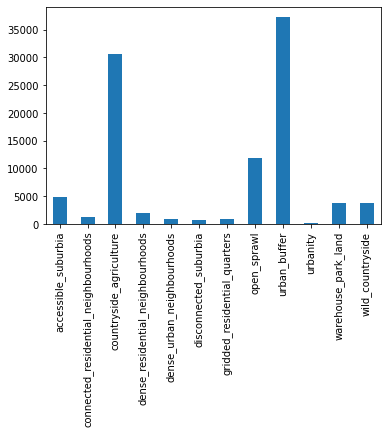

In [140]:
target.sum().plot.bar()

In [141]:
weights = target.sum().max() / target.sum()

In [143]:
# class_weights = {
#     0: 1,
#     1: 5,
#     2: 2,
#     3: 5,
#     4: 5,
#     5: 10,
#     6: 1,
#     7: 10,
#     8: 10,
#     9: 10,
#     10: 10,
#     11: 20,
#     12: 20,
#     13: 20,
# }
class_weights = {k:w for k, w in enumerate(weights.values)}

In [144]:
epochs = 5
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, class_weight=class_weights)

Epoch 1/5
2454/2454 [==============================] - 322s 129ms/step - loss: 0.2274 - mean_squared_error: 0.0567 - accuracy: 0.3443 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - val_accuracy: 0.3782
Epoch 2/5
2454/2454 [==============================] - 317s 129ms/step - loss: 0.2021 - mean_squared_error: 0.0542 - accuracy: 0.3720 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_accuracy: 0.3894
Epoch 3/5
2454/2454 [==============================] - 316s 129ms/step - loss: 0.1885 - mean_squared_error: 0.0531 - accuracy: 0.3905 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_accuracy: 0.3919
Epoch 4/5
2171/2454 [=========================>....] - ETA: 29s - loss: 0.1773 - mean_squared_error: 0.0522 - accuracy: 0.4060

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [145]:
y_pred_probs = model.predict(test_dataset)
y_pred = numpy.argmax(y_pred_probs, axis=1)
y = numpy.argmax(target_no_water.values[split:], axis=1)

In [30]:
def accuracy(y, y_pred):
    a = tf.keras.metrics.Accuracy()
    a.update_state(y, y_pred)
    return a.result().numpy()

In [33]:
# accuracy(y, y_pred) # all classes and custom weights

0.4537603

In [152]:
accuracy(y, y_pred)

0.42691934

See the probability distributions

<AxesSubplot:ylabel='Frequency'>

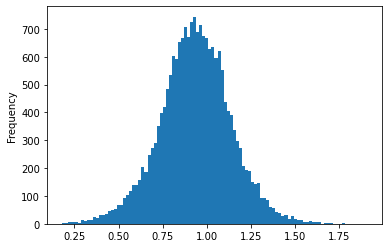

In [153]:
pandas.Series(y_pred_probs.sum(axis=1)).plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

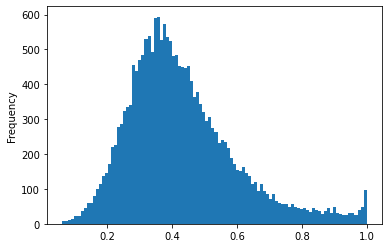

In [148]:
pandas.Series(y_pred_probs.max(axis=1)).plot.hist(bins=100)

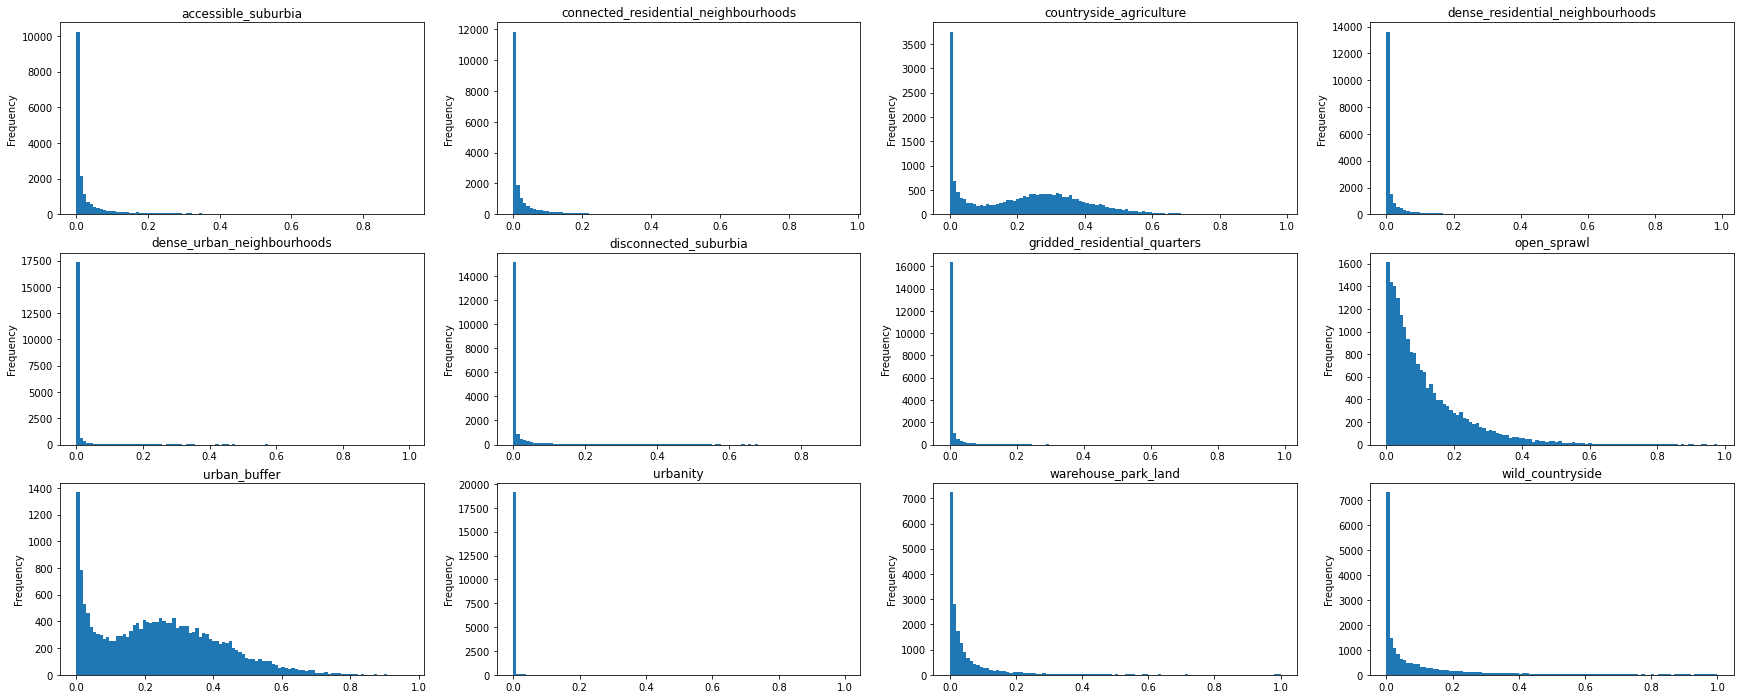

In [149]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(30, 12))
for i, (n, ax) in enumerate(zip(target.columns, axs.flatten())):
    pandas.Series(y_pred_probs[:, i]).plot.hist(bins=100, ax=ax)
    ax.set_title(n)

In [48]:
def confusion_matrix(y, y_pred, n_classes):
    cm = numpy.zeros((n_classes, n_classes), dtype=int)
    pairs = numpy.vstack((y, y_pred)).T
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            cm[c1, c2] = ((pairs[:, 0] == c1) * (pairs[:, 1] == c2)).sum()
    return cm

In [150]:
conf = confusion_matrix(y, y_pred, 12)

([<matplotlib.axis.YTick at 0x7f2bc937a7c0>,
 [Text(0, 0, 'accessible_suburbia'),
  Text(0, 1, 'connected_residential_neighbourhoods'),
  Text(0, 2, 'countryside_agriculture'),
  Text(0, 3, 'dense_residential_neighbourhoods'),
  Text(0, 4, 'dense_urban_neighbourhoods'),
  Text(0, 5, 'disconnected_suburbia'),
  Text(0, 6, 'gridded_residential_quarters'),
  Text(0, 7, 'open_sprawl'),
  Text(0, 8, 'urban_buffer'),
  Text(0, 9, 'urbanity'),
  Text(0, 10, 'warehouse_park_land'),
  Text(0, 11, 'wild_countryside')])

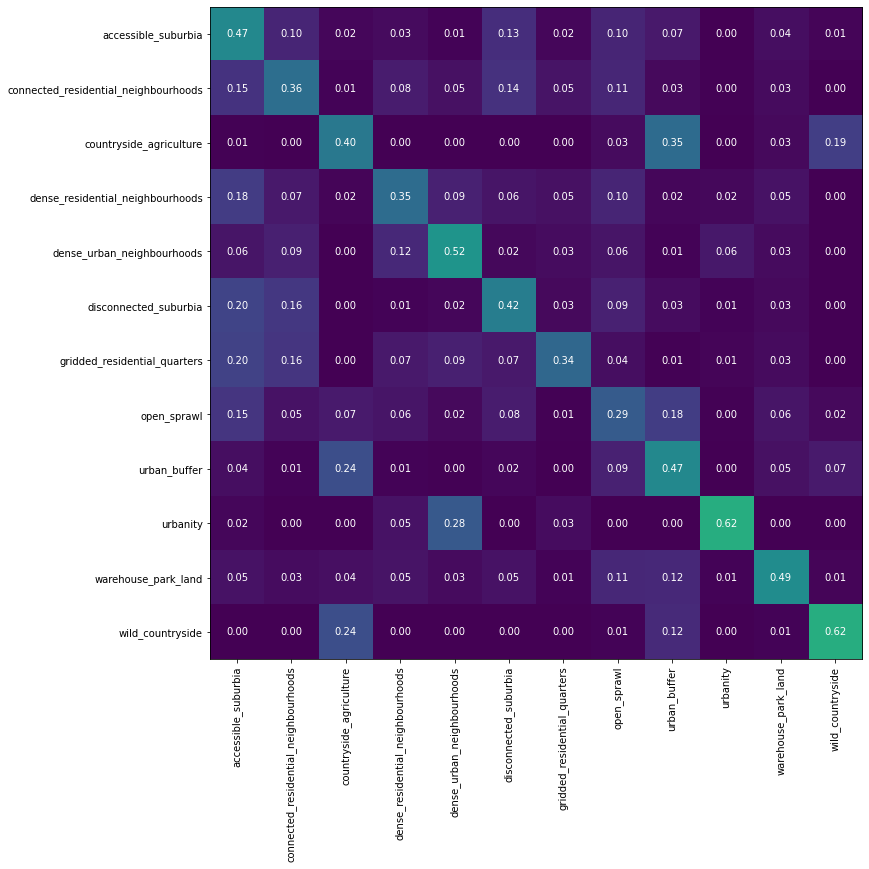

In [151]:
from itertools import product

fig, ax = plt.subplots(figsize=(12, 12))
a = conf
a = a / a.sum(axis=1)[:, numpy.newaxis]
a = pandas.DataFrame(a).values
ax.imshow(a, cmap="viridis", vmin=0, vmax=1)
for k, j in product(range(12), range(12)):
    ax.text(j, k, "{:.2f}".format(a[k, j]),
                   ha="center", va="center", color="w")
plt.xticks(range(12),target.columns, rotation=90)
plt.yticks(range(12),target.columns)


No class weights

In [60]:
base_model = keras.applications.EfficientNetB4(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False, # Do not include the ImageNet classifier at the top.
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(32, 32, 3))
x = preprocessing_and_augmentation(inputs)
x = preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(14, activation="sigmoid")(x)

model = keras.Model(inputs, predictions)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               229504    
                                                                 
 dense_5 (Dense)             (None, 14)                1806      
                                                           

In [61]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mean_squared_error", "accuracy"],
)

In [62]:
epochs = 2
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/2
2577/2577 [==============================] - 340s 130ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - accuracy: 0.4639 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_accuracy: 0.4751
Epoch 2/2
2577/2577 [==============================] - 335s 130ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - accuracy: 0.4994 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_accuracy: 0.5114


In [65]:
y_pred_probs_no_w = model.predict(test_dataset)
y_pred_no_w = numpy.argmax(y_pred_probs_no_w, axis=1)

In [66]:
accuracy(y, y_pred_no_w)

0.51135373

In [67]:
conf = confusion_matrix(y, y_pred_no_w, 14)

([<matplotlib.axis.YTick at 0x7f2bbf78d520>,
 [Text(0, 0, 'signature_type_0_0'),
  Text(0, 1, 'signature_type_1_0'),
  Text(0, 2, 'signature_type_3_0'),
  Text(0, 3, 'signature_type_4_0'),
  Text(0, 4, 'signature_type_5_0'),
  Text(0, 5, 'signature_type_6_0'),
  Text(0, 6, 'signature_type_7_0'),
  Text(0, 7, 'signature_type_8_0'),
  Text(0, 8, 'signature_type_2_0'),
  Text(0, 9, 'signature_type_2_1'),
  Text(0, 10, 'signature_type_2_2'),
  Text(0, 11, 'signature_type_9_0'),
  Text(0, 12, 'signature_type_9_2'),
  Text(0, 13, 'signature_type_9_4')])

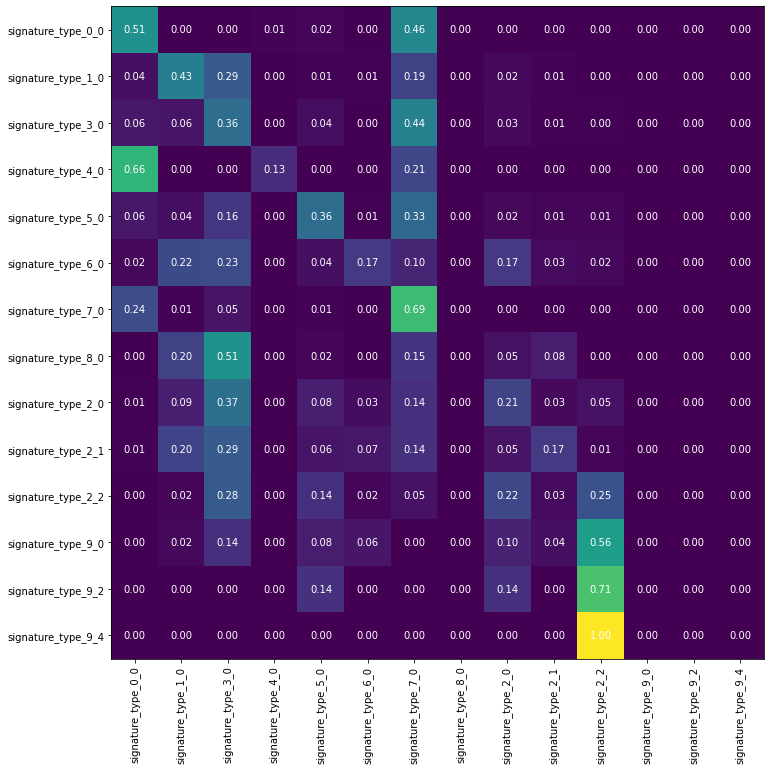

In [68]:
from itertools import product

fig, ax = plt.subplots(figsize=(12, 12))
a = conf
a = a / a.sum(axis=1)[:, numpy.newaxis]
a = pandas.DataFrame(a).values
ax.imshow(a, cmap="viridis", vmin=0, vmax=1)
for k, j in product(range(14), range(14)):
    ax.text(j, k, "{:.2f}".format(a[k, j]),
                   ha="center", va="center", color="w")
plt.xticks(range(14),types, rotation=90)
plt.yticks(range(14),types)
